

---


# Class incremental learning on the GTSRB dataset



---


This notebook contains several code snippets to help for your project:

- data loaders
- A baseline for incremental learning using fine-tuning
- Examples of how to use Weight & Biases for logging your results.



In [1]:
####################################
### Useful imports
############################

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# # Useful if you want to store intermediate results on your drive
# from google.colab import drive

# # Useful if you want to store intermediate results on your drive from google.colab import drive

# drive.mount('/content/gdrive/')
# DATA_DIR =  '/content/gdrive/MyDrive/teaching/ENSTA/2024'


Mounted at /content/gdrive/


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

Sun Jan  5 13:33:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data loaders

In [2]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
])

transform_train = v2.Compose([
    #v2.Grayscale(),
    #v2.RandomResizedCrop(32),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

# Define dataset and dataloader
def get_dataset(root_dir, transform, train=True):
    dataset = datasets.GTSRB(root=root_dir, split='train' if train else 'test', download=True, transform=transform)
    target = [data[1] for data in dataset]
    return dataset, target

def create_dataloader(dataset, targets, current_classes, batch_size, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [3]:
# Loads datasets (on your local computer)
root_dir = '/home/stephane/Documents/Onera/Cours/ENSTA/2025/data'

# Loads datasets (on Colab local computer)
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=True, transform=transform_train)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=True, transform=transform_test)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

# Loads target id lists and class names (not in torchvision dataset)
import csv
data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/test_target.csv', delimiter=',', header=None)
test_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/train_target.csv', delimiter=',', header=None)
train_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/signnames.csv')
class_names = data['SignName'].tolist()

100%|██████████| 187M/187M [00:01<00:00, 141MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:00<00:00, 191MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 2.88MB/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb
Train dataset contains 26640 images
Test dataset contains 12630 images


## Display of images

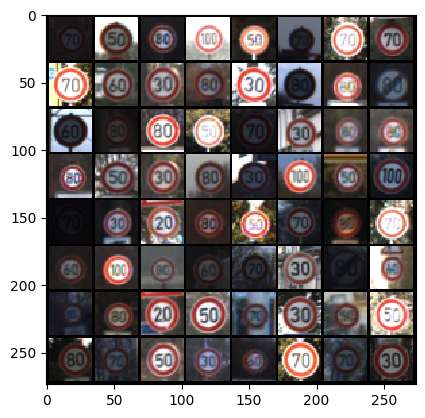

torch.Size([64, 3, 32, 32])


In [4]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
#random.shuffle(all_classes)
classes_per_task = 8
current_classes = []

task = 0
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

# Create data for first task
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)     ## 64 is the batch
                        ## 1 for grey values --  3 for RGB
                        ## 32x32 for mage size (small here)


In [5]:
test_loader = create_dataloader(train_dataset, train_target, all_classes, batch_size, shuffle = True)

# Get the data from the test set and computes statistics
# gtsrbtest_gt = []
# for _, targets in test_loader:
#   gtsrbtest_gt += targets.numpy().tolist()
# print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicycles cr

## Simple networks

In [6]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc = nn.Linear(4096, n_out)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.fc(x) ## on finit exactement de la même façon

        return x

# Another simple model (compare them using torchinfo below)
class SimpleCNN2(nn.Module):
    def __init__(self, n_out=10, n_in=1):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc = nn.Linear(128, n_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc(x)
        return x

In [7]:
!pip install torchinfo
from torchinfo import summary

model = SimpleCNN2(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

model = SimpleCNN(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

#print(model)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN2                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─ReLU: 1-2                              [64, 32, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 32, 16, 16]          --
├─Conv2d: 1-4                            [64, 64, 16, 16]          18,496
├─ReLU: 1-5                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [64, 64, 8, 8]            --
├─Linear: 1-7                            [64, 128]                 524,416
├─ReLU: 1-8                              [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 395.40
Input size (MB): 0.79
Forward/backward pass size (MB): 25.24
Params size (MB): 2.18
Estimated Tota

## Baseline for incremental learning

In [8]:
from torch.optim import lr_scheduler
import torch.nn.init as init

# Evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, ncols=80):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Simple Training loop
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()

    for images, labels in tqdm(train_loader, ncols=80,  desc="Epoch {}".format(epoch)):   #ajouter d'autres données, techniques memory buffer,
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def initialize_weights(module):
    """Initializes the weights of a PyTorch module using Xavier/Glorot initialization."""
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):  # Check for relevant layers
        init.xavier_uniform_(module.weight) #Xavier uniform initialization
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize bias to zero
    elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)): #Initialize normalization layers
        if module.weight is not None:
            init.ones_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)


# Main training loop for incremental learning
def incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss() #peut être changé comme critère
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs as needed
            train(model, train_loader, optimizer, criterion, device, epoch)
            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

    return accuracies



## Weight & Biases

You can use this environement to log your learning.

The code below provides a version of the class incremental function that stores learning curves and the seauence of accuracies for each increment of classes.

Tu use it, create an account at: https://wandb.ai/

In [9]:
###################################
##### For using Weight & Biases
###############

!pip install wandb -qU

import wandb

wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mhiriganada (mhiriganada-iogs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
import math
# Simple Training loop
def train_wandb(model, train_loader, optimizer, criterion, device, epoch):

    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1


# Main training loop for incremental learning
def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            #train(model, train_loader, optimizer, criterion, device, epoch)

            # If logging training (but not incremental)
            train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            #wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Log train and validation metrics to wandb

    return accuracies



## Pre-Training

In [11]:
# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks #43/2 ~ 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200 # Adjust rehearsal set size
alignment_strength = 0.1 # Adjust alignment strength
num_epochs = 4

#model = SimpleCNN(n_out = 1, n_in = 3).to(device)
#model.apply(initialize_weights)

# The name of the network (choose the on you want)
tag = "simpleCNN_GTSRB_pretrained"
netname = os.path.join(root_dir, 'network_{:s}.pth'.format(tag))

#################################################
## Pre-training
####

# Read the last learned network (if stored)
if (os.path.exists(netname)):
    print('Load pre-trained network')
    model = SimpleCNN(n_in = 3, n_out=classes_per_task)
    model.load_state_dict(torch.load(netname,weights_only=True))

    #model = torch.load(netname, weights_only=True)
    model = model.to(device)
else:
    print('Pretrain')
    model = SimpleCNN(n_in = 3, n_out=1)
    model.apply(initialize_weights)
    model.to(device)

    accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                        1, classes_per_task, batch_size, num_epochs, lr, device)

    print(f"!!!!! Pre-training on first task  = {accu[0]:.2f}%")

    # Save last learned model
    #torch.save(model, netname)
    torch.save(model.state_dict(), netname)

## Copy model to have the same initialization
copy_model = copy.deepcopy(model) # Copy model to start from the same initialization

#### Learn with a single epoch in incremental (faster but less accurate)
num_epochs = 1


Pretrain
Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 27.74it/s]


Task 1, Epoch 1: Accuracy Train = 60.92%


100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 39.19it/s]


Task 1, Epoch 2: Accuracy Train = 89.79%


100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 38.38it/s]


Task 1, Epoch 3: Accuracy Train = 94.83%


100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 38.02it/s]


Task 1, Epoch 4: Accuracy Train = 97.57%


100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 28.61it/s]

Task 1: Accuracy Test = 87.42%
!!!!! Pre-training on first task  = 87.42%


## Fine tuning

In [12]:
#############################################
## Fine tuning
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Fine tuning",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Simple Incremental Fine Tuning
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:03, 34.96it/s]
100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 37.31it/s]


Task 1, Epoch 1: Accuracy Train = 95.45%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 37.69it/s]


Task 1: Accuracy Test = 87.78%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 126it [00:04, 27.77it/s]
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 37.90it/s]


Task 2, Epoch 1: Accuracy Train = 99.38%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 37.55it/s]


Task 2: Accuracy Test = 47.34%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 49it [00:01, 33.41it/s]
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 27.78it/s]


Task 3, Epoch 1: Accuracy Train = 97.21%


100%|█████████████████████████████████████████| 144/144 [00:05<00:00, 25.29it/s]


Task 3: Accuracy Test = 12.57%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 50it [00:01, 33.16it/s]
100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 37.77it/s]


Task 4, Epoch 1: Accuracy Train = 90.22%


100%|█████████████████████████████████████████| 167/167 [00:05<00:00, 30.84it/s]


Task 4: Accuracy Test = 10.08%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 60it [00:02, 25.26it/s]
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 39.34it/s]


Task 5, Epoch 1: Accuracy Train = 96.59%


100%|█████████████████████████████████████████| 194/194 [00:05<00:00, 38.44it/s]

Task 5: Accuracy Test = 12.12%


incremental_accuracy,█▄▁▁▁
task,▁▃▅▆█
train/train_loss,▆▂▂▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▇▅▂▂▂▂▂▂▂█▆▄▄▆▆▂▂▂
incremental_accuracy,12.12268
task,4
train/train_loss,0.15493


## Upper bound

In [13]:
#################################################
## Global upper bound (all data, all classes)
####

# One task + all classes computed using 5 epochs

model = copy.deepcopy(copy_model)
accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      1, (numclasses // num_tasks) * num_tasks, batch_size, 5, lr, device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 35.73it/s]


Task 1, Epoch 1: Accuracy Train = 98.31%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 36.24it/s]


Task 1, Epoch 2: Accuracy Train = 99.43%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 35.33it/s]


Task 1, Epoch 3: Accuracy Train = 99.28%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 35.46it/s]


Task 1, Epoch 4: Accuracy Train = 99.33%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 36.73it/s]


Task 1, Epoch 5: Accuracy Train = 99.70%


100%|█████████████████████████████████████████| 194/194 [00:05<00:00, 37.47it/s]

Task 1: Accuracy Test = 89.22%
!!!!! Upper bound of accuracy = 89.22%


In [14]:
########################################
## Upper bound for each task (takes some time)
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Non incremental data (learn all classes from all data for each task)
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = True)

wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:03, 33.80it/s]
100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 34.72it/s]


Task 1, Epoch 1: Accuracy Train = 56.64%


100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 29.16it/s]


Task 1: Accuracy Test = 39.79%
Starting Task 2 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 250it [00:07, 35.09it/s]
100%|█████████████████████████████████████████| 250/250 [00:07<00:00, 34.25it/s]


Task 2, Epoch 1: Accuracy Train = 85.91%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 37.32it/s]


Task 2: Accuracy Test = 75.38%
Starting Task 3 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 299it [00:09, 31.64it/s]
100%|█████████████████████████████████████████| 299/299 [00:07<00:00, 37.98it/s]


Task 3, Epoch 1: Accuracy Train = 92.47%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 31.79it/s]


Task 3: Accuracy Test = 82.56%
Starting Task 4 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 348it [00:10, 32.45it/s]
100%|█████████████████████████████████████████| 348/348 [00:09<00:00, 36.35it/s]


Task 4, Epoch 1: Accuracy Train = 93.51%


100%|█████████████████████████████████████████| 167/167 [00:05<00:00, 32.34it/s]


Task 4: Accuracy Test = 79.45%
Starting Task 5 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 407it [00:12, 31.75it/s]
100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 35.69it/s]


Task 5, Epoch 1: Accuracy Train = 94.77%


100%|█████████████████████████████████████████| 194/194 [00:05<00:00, 36.19it/s]

Task 5: Accuracy Test = 82.46%


incremental_accuracy,▁▇█▇█
task,▁▃▅▆█
train/train_loss,▅▅▅▄▄▆▆▄▄▃▂▂▂█▆▄▃▂▂▂▁▁▁█▆▃▂▂▂▂▂▂▂▁▁▄▄▂▂▁
incremental_accuracy,82.46166
task,4
train/train_loss,0.42809
